## Utils

In [1]:
import pickle as pkl
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import Dataset
import torch
import random

C:\Users\tsl62\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
def weightedMean(data, weights, flux = False):
    #expects: data = array of means, weights = array of std. devs
    #computes the weighted mean with weight = 1/var^2

    if(flux):
        #convert everything to flux first
        weights = [magToFluxErr(data[i], weights[i]) for i in range(len(data))]
        data = [magToFlux(i) for i in data]
    
    sum = 0
    sum_weights = 0
    
    for i in range(len(data)):
        weight = 1 / (weights[i]**2)
        sum_weights += weight

        sum += weight * data[i]

    wmean = sum/sum_weights
    wmean_err = np.sqrt(1/sum_weights)

    if(flux):
        #convert back to magnitude
        wmean_err = fluxToMagErr(wmean, wmean_err)
        wmean = fluxToMag(wmean)

    return wmean, wmean_err

def fluxToMag(f):
    m  = -2.5 * np.log10(f)
    return m

def magToFlux(m):
    f = 10**(-0.4*m)
    return f

def fluxToMagErr(f, df):
    dm = np.abs(2.5 / np.log(10) * df / f)

    return dm

def magToFluxErr(m, dm):
    df = np.abs(dm * 10**(-0.4*m) * np.log(10)/-2.5)
    return df

In [37]:
#Check that the functions are working correctly
print(magToFluxErr(21, 1))
print(magToFlux(21))
print(fluxToMagErr(magToFlux(21), magToFluxErr(21, 1)))
print(fluxToMag(magToFlux(21)))

3.6667025453220804e-09
3.981071705534969e-09
0.9999999999999998
21.0


In [38]:
def plot_with_desi(data, err, dates, DESI_date, targetID, flux = False):
    wmean, wmean_err = weightedMean(data, err, flux)
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    fig.suptitle(f"ZTF Magnitude with Error for {targetID}")
    ax.errorbar(dates, data, yerr = err, fmt="o", label = "ZTF Mag. w/ Error")
    ax.axhline(wmean, c = "orange", label = "Mean Mag. w/ Error")
    ax.axhline(wmean + wmean_err, c = "orange", linestyle = "--")
    ax.axhline(wmean - wmean_err, c = "orange", linestyle = "--")
    
    ax.axvline(DESI_date, c = "red", label = "DESI observation date")
    fig.legend()

In [57]:
def generate_plots(path, dates_path, n, flux = False):
    load = h5py.File(path, 'r')
    dates = pd.read_hdf(dates_path)

    for i in range(n):
        field = random.choice(np.asarray(load["fields"]))
        datafile = load["fields"][field]
        while (len(np.asarray(datafile)) ==0):
            field = random.choice(np.asarray(load["fields"]))
            datafile = load["fields"][field]
            
        key = random.choice(np.asarray(datafile))

        for channel in ["g", "i", "r"]:
            obs = datafile[key][channel]
            if(len(obs) == 0):
                continue
            if(len(DESI_date) == 0):
                continue
            DESI_date = DESI_date[0]
            
            mag = np.asarray(obs["mag"])
            magerr = np.asarray(obs["magerr"])
            date = np.asarray(obs["hmjd"])

            plot_with_desi(mag, magerr, date, DESI_date, key, flux)

## Visualize Sample DESI Data

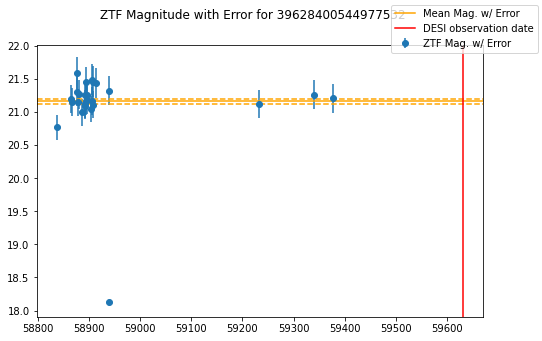

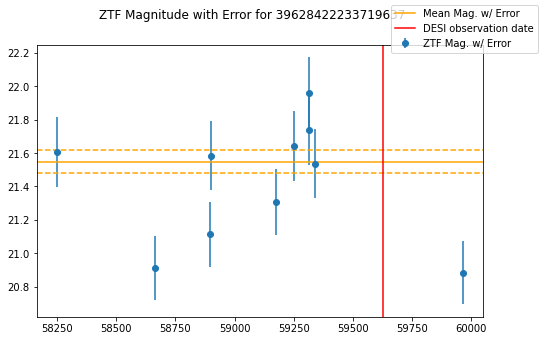

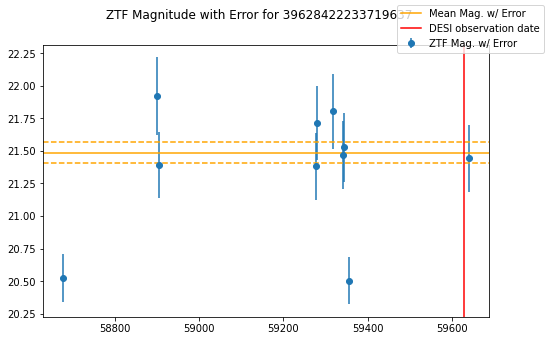

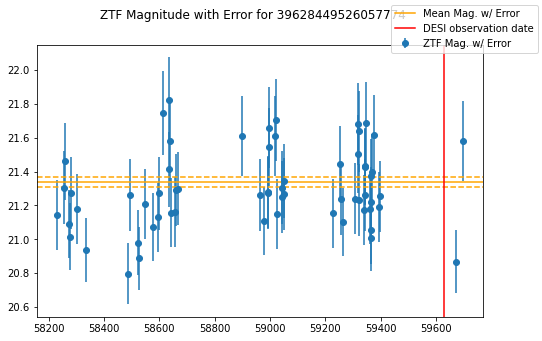

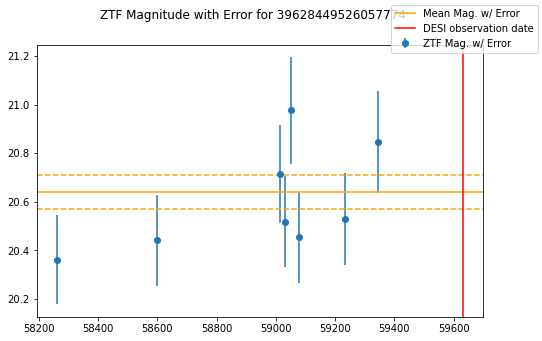

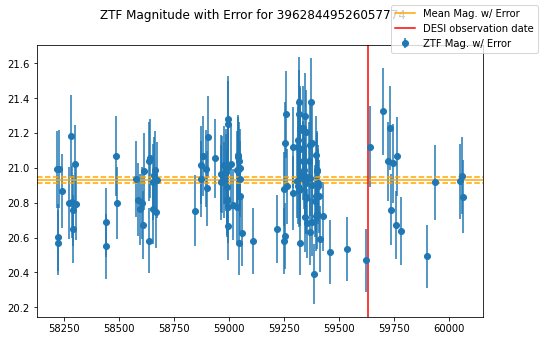

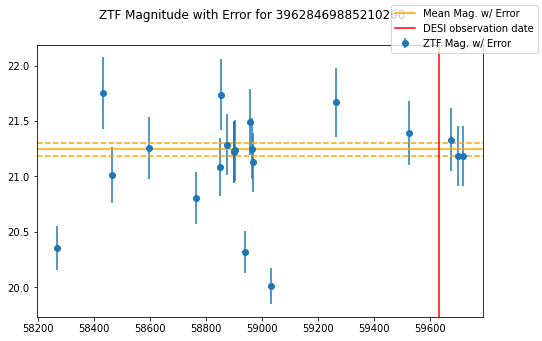

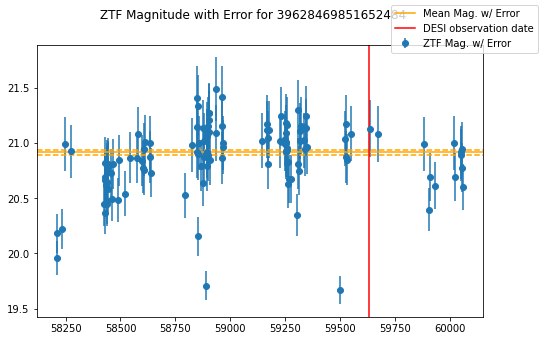

In [40]:
generate_plots("../../data/targetidLC.hdf5", "../../data/dates.hdf5", 5, flux = True)

In [27]:
def plot_with_desi_compare(data, err, dates, DESI_date, targetID):
    wmean, wmean_err = weightedMean(data, err, False)
    wmean_f, wmean_err_f = weightedMean(data, err, True)
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    fig.suptitle(f"ZTF Magnitude with Error for {targetID}")
    ax.errorbar(dates, data, yerr = err, fmt="o", label = "ZTF Mag. w/ Error")
    ax.axhline(wmean, c = "orange", label = "Mean Mag. w/ Error")
    ax.axhline(wmean + wmean_err, c = "orange", linestyle = "--")
    ax.axhline(wmean - wmean_err, c = "orange", linestyle = "--")

    ax.axhline(wmean_f, c = "green", label = "Mean Mag. w/ Error (flux)")
    ax.axhline(wmean_f + wmean_err_f, c = "green", linestyle = "--")
    ax.axhline(wmean_f - wmean_err_f, c = "green", linestyle = "--")
    
    ax.axvline(DESI_date, c = "red", label = "DESI observation date")
    fig.legend()

In [75]:
def generate_plots_compare(path, dates_path, n, flux = False):
    load = h5py.File(path, 'r')
    dates = pd.read_hdf(dates_path)

    for i in range(n):
        field = random.choice(np.asarray(load["fields"]))
        datafile = load["fields"][field]
        while (len(np.asarray(datafile)) ==0):
            field = random.choice(np.asarray(load["fields"]))
            datafile = load["fields"][field]
            
        key = random.choice(np.asarray(datafile))

        for channel in ["g", "i", "r"]:
            obs = datafile[key][channel]
            if(len(obs) == 0):
                continue
            DESI_date = np.asarray(dates[dates["targetid"] == int(key)]["mjd"])
            if(len(DESI_date) == 0):
                continue
            DESI_date = DESI_date[0]
            mag = np.asarray(obs["mag"])
            magerr = np.asarray(obs["magerr"])
            date = np.asarray(obs["hmjd"])

            plot_with_desi_compare(mag, magerr, date, DESI_date, key)

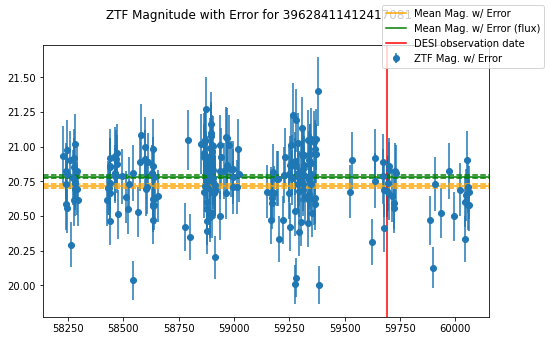

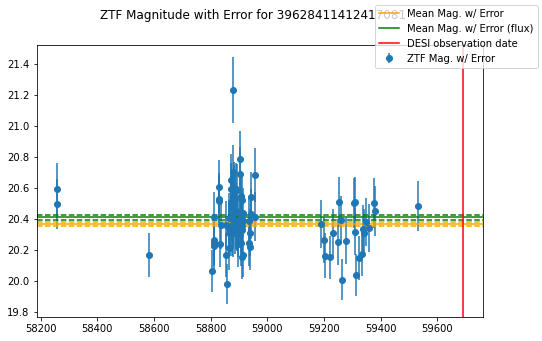

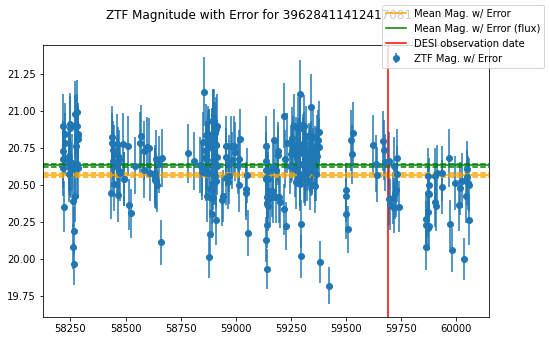

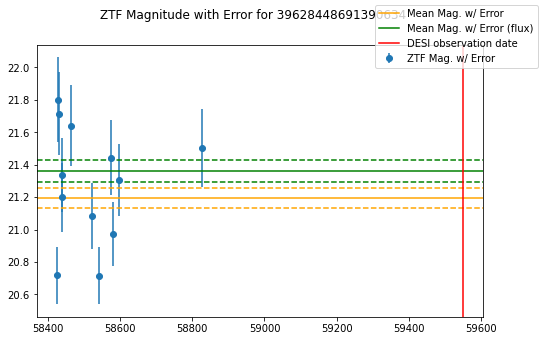

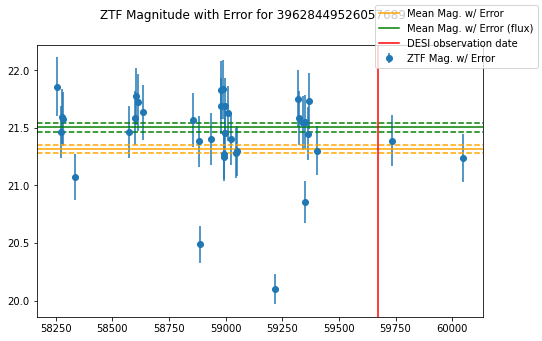

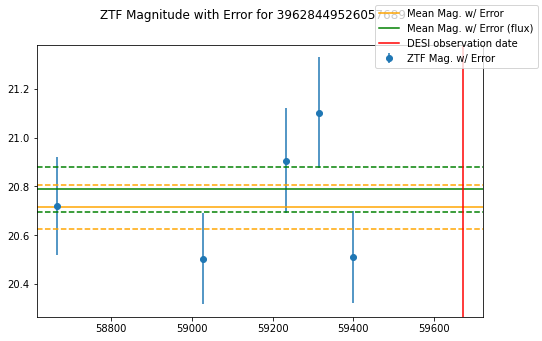

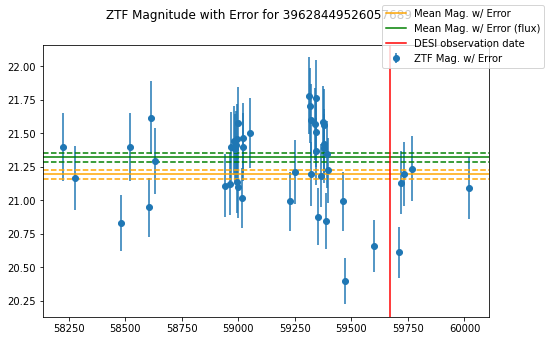

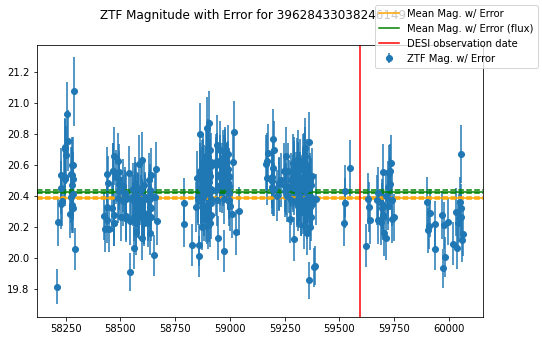

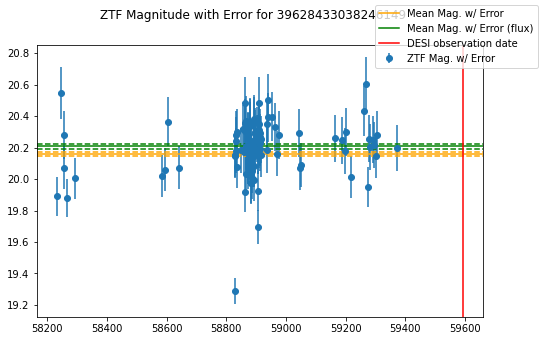

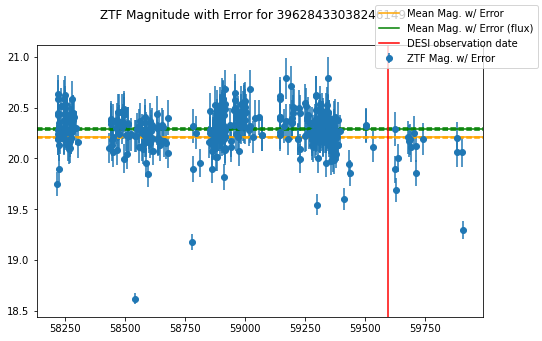

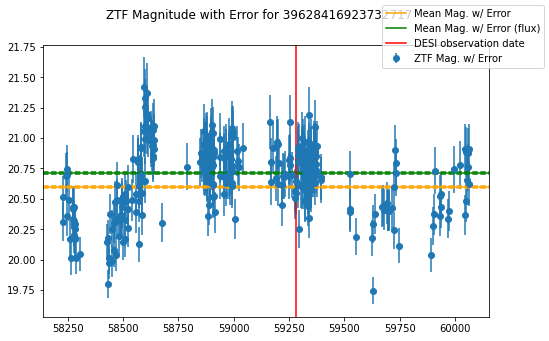

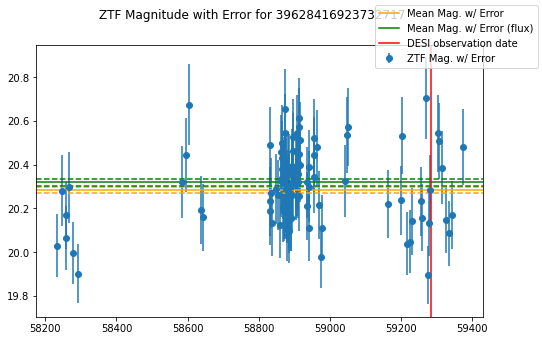

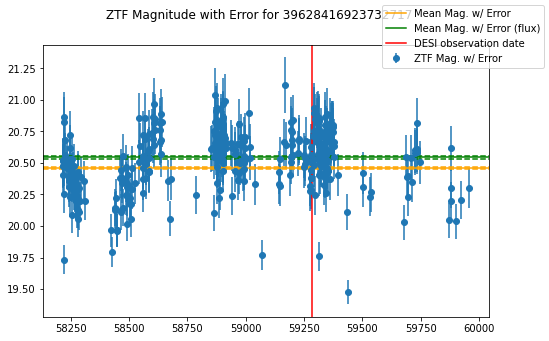

In [76]:
generate_plots_compare("../../data/targetidLC.hdf5", "../../data/dates.hdf5", 5, flux = True)

## Calculated Weighted Means

In [45]:
def read_ztf_from_h5py(path):
    load = h5py.File(path, 'r')
    targets = []

    def get_channel_mean(datafile, key, channel):
        ch = datafile[key][channel]
        if(len(ch) < 4):
            return None, None
        
        mag = np.asarray(ch["mag"])
        magerr = np.asarray(ch["magerr"])
        return weightedMean(mag, magerr)

    for field in load["fields"]:
        datafile = load["fields"][field]
        for key in datafile.keys():
            obs = {}
            obs["targetid"] = key
            for channel in ["g", "i", "r"]:
                mag, err = get_channel_mean(datafile, key, channel)
                obs[channel + "_mag"] = mag
                obs[channel + "_err"] = err
                
            targets.append(obs)
    return targets

In [46]:
means = read_ztf_from_h5py("../../data/targetidLC.hdf5")

with open('mean_mags.json', 'w') as f:
    json.dump(means, f)

In [48]:
with open('mean_mags.json') as f:
    means = json.load(f)

## Generate PyTorch Dataset

In [49]:
class ZTFMagDataset(Dataset):
    def __init__(self, file_path, mode="h5py"):
        if(mode == "h5py"):
            self.means = read_ztf_from_h5py(file_path)
        else:
            with open('mean_mags.json') as f:
                self.means = json.load(f)
    
    def __len__(self):
        return len(self.means)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return self.means[idx]

In [50]:
test_dataset = ZTFMagDataset('mean_mags.json', "json")
test_dataset.__getitem__(0)

{'targetid': '39628317598417761',
 'g_mag': None,
 'g_err': None,
 'i_mag': None,
 'i_err': None,
 'r_mag': 21.192472839462514,
 'r_err': 0.027557298995896623}

In [4]:
num_mult_channels = 0
total_targets = 0
for i in range(10):
    hdf_path = f"../../data/lc/00062{i}.hdf5"
    
    load = h5py.File(hdf_path, 'r')
    for key in load.keys():
        length = len(np.array(load[key]["r"])) + len(np.array(load[key]["g"])) + len(np.array(load[key]["i"]))
        total_targets +=1
        if length > 4:
            num_mult_channels += length // 4

print(f"{total_targets} total targetIDs")
print(f"{num_mult_channels/total_targets} average filters per targetID")

11231 total targetIDs
1.4059300151366754 average filters per targetID


## Experiment: Window

In [127]:
def weightedMeanDate(data, weights, dates, obs_date, tolerance, flux = False):
    #expects: data = array of means, weights = array of std. devs
    #computes the weighted mean with weight = 1/var^2

    if(flux):
        #convert everything to flux first
        weights = [magToFluxErr(data[i], weights[i]) for i in range(len(data))]
        data = [magToFlux(i) for i in data]
    
    sum = 0
    sum_weights = 0
    
    for i in range(len(data)):
        if(np.abs(dates[i] - obs_date) < tolerance):
            weight = 1 / (weights[i]**2)
            sum_weights += weight

            sum += weight * data[i]

    if sum_weights == 0:
        return None, None
    
    wmean = sum/sum_weights
    wmean_err = np.sqrt(1/sum_weights)

    if(flux):
        #convert back to magnitude
        wmean_err = fluxToMagErr(wmean, wmean_err)
        wmean = fluxToMag(wmean)

    return wmean, wmean_err


In [116]:
def preprocess_data(path, dates_path):
    dates = pd.read_hdf(dates_path)
    load = h5py.File(path, 'r')
    targets = []

    for field in load["fields"]:
        datafile = load["fields"][field]
        for key in datafile.keys():
            obs = {}
            for item in datafile[key].keys():
                obs[item] = datafile[key][item]
            
            DESI_date = np.asarray(dates[dates["targetid"] == int(key)]["mjd"])
            if(len(DESI_date) == 0):
                return None
            DESI_date = DESI_date[0]

            obs["desi_date"] = DESI_date
            obs["targetid"] = key

                
            targets.append(obs)
    return targets

In [80]:
def read_ztf_from_h5py_dateWindow(path, dates_path, window):
    dates = pd.read_hdf(dates_path)
    load = h5py.File(path, 'r')
    targets = []

    def get_channel_mean(datafile, key, channel):
        ch = datafile[key][channel]
        if(len(ch) < 4):
            return None, None
        
        mag = np.asarray(ch["mag"])
        magerr = np.asarray(ch["magerr"])

        DESI_date = np.asarray(dates[dates["targetid"] == int(key)]["mjd"])
        if(len(DESI_date) == 0):
            return None
        DESI_date = DESI_date[0]
        
        return weightedMeanDate(mag, magerr, np.asarray(ch["hmjd"]), DESI_date, window, True)

    for field in load["fields"]:
        datafile = load["fields"][field]
        for key in datafile.keys():
            obs = {}
            obs["targetid"] = key
            for channel in ["g", "i", "r"]:
                mag, err = get_channel_mean(datafile, key, channel)
                obs[channel + "_mag"] = mag
                obs[channel + "_err"] = err
                
            targets.append(obs)
    return targets

In [112]:
targets = read_ztf_from_h5py_dateWindow("../../data/targetidLC.hdf5", "../../data/dates.hdf5", 1000)

KeyboardInterrupt: 

In [117]:
data = preprocess_data("../../data/targetidLC.hdf5", "../../data/dates.hdf5")

In [118]:
data[0]

{'g': <HDF5 group "/39628317598417761/g" (0 members)>,
 'i': <HDF5 group "/39628317598417761/i" (0 members)>,
 'r': <HDF5 group "/39628317598417761/r" (4 members)>,
 'desi_date': 59630.27748365,
 'targetid': '39628317598417761'}

In [120]:
def calculate_mean_from_dict(dict, window):
    targets = []

    def get_channel_mean(datafile, channel):
        ch = datafile[channel]
        if(len(ch) < 4):
            return None, None
        
        mag = np.asarray(ch["mag"])
        magerr = np.asarray(ch["magerr"])

        DESI_date = datafile["desi_date"]
        if(DESI_date == None):
            return None
        
        return weightedMeanDate(mag, magerr, np.asarray(ch["hmjd"]), DESI_date, window, True)


    for item in dict:
        obs = {}
        obs["targetid"] = item["targetid"]
        for channel in ["g", "i", "r"]:
            mag, err = get_channel_mean(item, channel)
            obs[channel + "_mag"] = mag
            obs[channel + "_err"] = err
            
        targets.append(obs)
    return targets

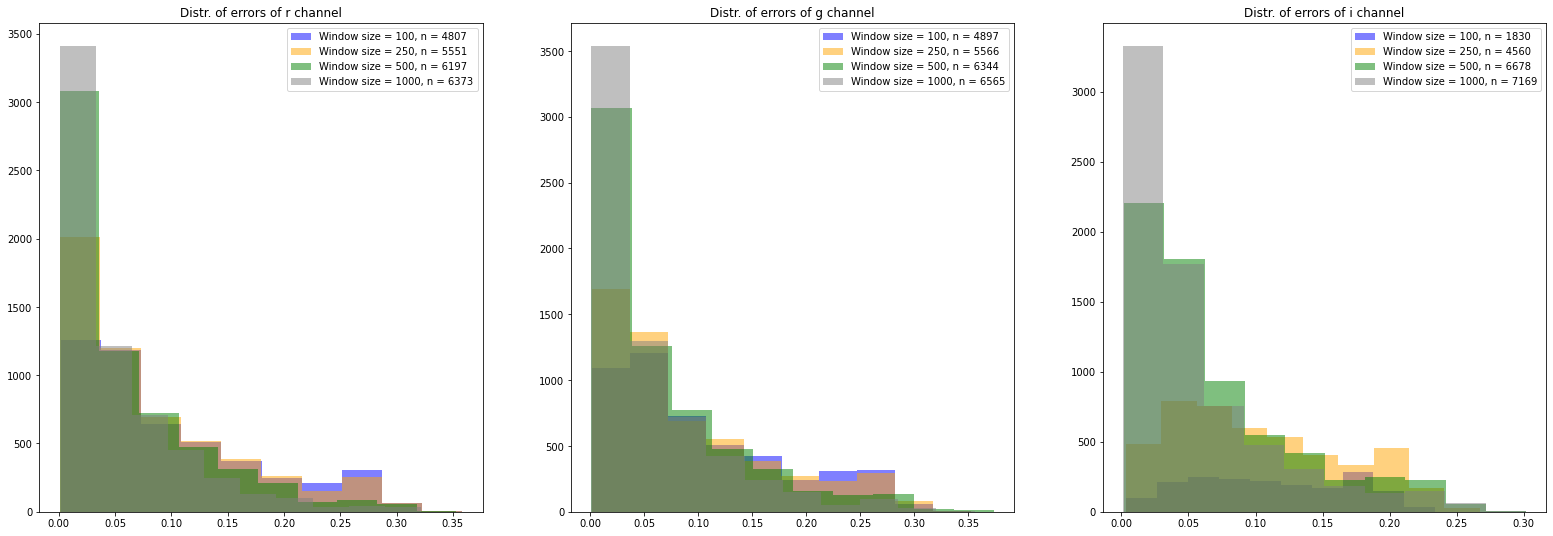

In [130]:
windows = [100, 250, 500, 1000]
colors = ["blue", "orange", "green", "gray"]

fig, ax = plt.subplots(1, 3, figsize=(27, 9))
for i in range(len(windows)):
    window = windows[i]
    
    targets = calculate_mean_from_dict(data, window)

    r_err = []
    g_err = []
    i_err = []
    
    for obs in targets:
        if(obs["i_err"] != None):
            i_err.append(obs["i_err"])
        if(obs["g_err"] != None):
            g_err.append(obs["g_err"])
        if(obs["r_err"] != None):
            r_err.append(obs["r_err"])

    ax[0].hist(r_err, color = colors[i], label = f"Window size = {window}, n = {len(r_err)}", alpha = 0.5)
    ax[1].hist(g_err, color = colors[i], label = f"Window size = {window}, n = {len(g_err)}", alpha = 0.5)
    ax[2].hist(i_err, color = colors[i], label = f"Window size = {window}, n = {len(i_err)}", alpha = 0.5)

ax[0].set_title("Distr. of errors of r channel")
ax[1].set_title("Distr. of errors of g channel")
ax[2].set_title("Distr. of errors of i channel")

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.show()
